In [1]:
%pip install stable-baselines3 numpy torch supersuit pettingzoo pymunk scipy gymnasium matplotlib einops tensorboard wandb imageio
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from stable_baselines3 import SAC
from __future__ import annotations
import glob
import os
import time
from datetime import datetime
import supersuit as ss
from pettingzoo.mpe import simple_adversary_v3

import os
import random
import time
from distutils.util import strtobool
from typing import Dict
import matplotlib.pyplot as plt
import imageio
import einops
import gymnasium as gym
from pettingzoo import ParallelEnv
from pettingzoo.mpe import simple_spread_v3
from pettingzoo.mpe import simple_v3
from pettingzoo.butterfly import knights_archers_zombies_v10

from pettingzoo.utils.env import AgentID, ObsType
from torch.utils.tensorboard import SummaryWriter

from MASAC.masac.ma_buffer import MAReplayBuffer, Experience
from MASAC.masac.masac import concat_id
from argparse import Namespace


Note: you may need to restart the kernel to use updated packages.


In [2]:

total_timesteps = 5000
time_now = datetime.now()
exp_name = 'Circle_simple'
os.makedirs('output/'+exp_name, exist_ok=True)
# Definicja obiektu args z wymaganymi parametrami
args = Namespace(
    exp_name=exp_name,                      # Nazwa eksperymentu
    seed=12,                                # Seed dla losowości
    torch_deterministic=True,               # Czy używać deterministycznych operacji w PyTorch
    cuda=True,                              # Czy używać CUDA (GPU)
    track=False,                            # Czy śledzić eksperyment (np. za pomocą wandb)
    wandb_project_name="Project_" + exp_name + str(time_now.hour) + ":" + str(time_now.minute),        # Nazwa projektu w wandb
    wandb_entity='Entity_' + exp_name,               # Entity w wandb
    capture_video=False,                    # Czy przechwytywać wideo
    total_timesteps= total_timesteps,                 # Całkowita liczba kroków treningowych
    buffer_size=1000000,                    # Rozmiar bufora replay
    gamma=0.995,                             # Discount factor
    tau=0.01,                              # Współczynnik tau do aktualizacji sieci docelowych
    batch_size=2054,                         # Rozmiar batcha
    learning_starts=total_timesteps/10,                   # Krok, po którym zaczyna się nauka
    policy_lr=5e-4,                         # Learning rate dla polityki
    q_lr=5e-4,                              # Learning rate dla Q-function
    policy_frequency=1,                     # Częstotliwość aktualizacji polityki
    target_network_frequency=1,             # Częstotliwość aktualizacji sieci docelowych
    alpha=0.2,                              # Waga entropii
    autotune=True,                           # Czy automatycznie dostrajać alpha
    save_frequency = total_timesteps/10,                  # Częstotliwość zapisywania modeli
    actor_path='output/'+exp_name+"/",                     # Ścieżka do zapisu modelu aktora
)

# env setup
env = simple_v3.parallel_env(render_mode=None,  continuous_actions=True)
# env = simple_spread_v3.parallel_env(render_mode=None, N=3, local_ratio=0.5, max_cycles=25, continuous_actions=True)
env.reset(seed=args.seed)

({'agent_0': array([ 0.        ,  0.        , -0.12300815, -1.5349231 ], dtype=float32)},
 {'agent_0': {}})

In [3]:
class SoftQNetwork(nn.Module):
    def __init__(self, env: ParallelEnv):
        super().__init__()
        single_action_space = env.action_space(env.agents[0])
        # Global state, joint actions space -> ... -> Q value
        self.fc1 = nn.Linear(np.array(env.state().shape).prod() + np.prod(single_action_space.shape) * env.num_agents, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x, a):
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5

class Actor(nn.Module):
    def __init__(self, env: ParallelEnv):
        super().__init__()
        if not hasattr(env, 'possible_agents'):
            raise AttributeError("Środowisko nie ma atrybutu 'possible_agents'. Upewnij się, że używasz PettingZoo parallel_env.")

        single_action_space = env.action_space(env.agents[0])
        single_observation_space = env.observation_space(env.agents[0])
        # Local state, agent id -> ... -> local action
        self.fc1 = nn.Linear(np.array(single_observation_space.shape).prod() + 1, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(single_action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((single_action_space.high - single_action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((single_action_space.high + single_action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean


In [5]:
# Klasa do zbierania i wyświetlania zwrotów z epizodów
class Plotter:
    def __init__(self):
        self.returns_trained = []
        self.episodes_trained = []
        self.returns_random = []
        self.episodes_random = []

    def add_return(self, episode, return_value, agent_type='trained'):
        if agent_type == 'trained':
            self.episodes_trained.append(episode)
            self.returns_trained.append(return_value)
        elif agent_type == 'random':
            self.episodes_random.append(episode)
            self.returns_random.append(return_value)

    def plot_returns(self):
        plt.figure(figsize=(12,6))
        plt.plot(self.episodes_trained, self.returns_trained, label='Wytrenowany Agent', marker='o')
        plt.plot(self.episodes_random, self.returns_random, label='Agent Losowy', marker='x')
        plt.xlabel('Epizod')
        plt.ylabel('Zwrot')
        plt.title('Porównanie Zwrotów: Wytrenowany Agent vs Agent Losowy')
        plt.legend()
        plt.grid(True)
        plt.show()

# Klasa do wizualizacji działania agenta
class AgentVisualizer:
    def __init__(self, actor_path, device='cpu'):
        """
        Inicjalizuje wizualizatora agenta.

        Args:
            actor_path (str): Ścieżka do pliku z zapisanym modelem aktora (actor.pth).
            device (str, optional): Urządzenie do obliczeń ('cpu' lub 'cuda'). Domyślnie 'cpu'.
        """
        self.device = torch.device(device if torch.cuda.is_available() and device == 'cuda' else 'cpu')
        # Używamy oryginalnego środowiska PettingZoo z renderowaniem 'rgb_array'

        self.env = env
        # self.env = simple_spread_v3.parallel_env(
        #     N=3, 
        #     local_ratio=0.5, 
        #     max_cycles=25, 
        #     continuous_actions=True,
        #     render_mode="rgb_array"  # Poprawne ustawienie render_mode
        # )
        self.actor = Actor(self.env)
        self.actor.load_state_dict(torch.load(actor_path, map_location=self.device))
        self.actor.to(self.device)
        self.actor.eval()
        self.plotter = Plotter()

        # Sprawdzenie dostępnych trybów renderowania
        available_render_modes = self.env.metadata.get('render_modes', None)
        print("Dostępne tryby renderowania:", available_render_modes)

    def run_episodes(self, num_episodes=10, agent_type='trained', render=False, save_gif=False, gif_path='agent_demo.gif'):
        """
        Uruchamia określoną liczbę epizodów z wytrenowanym lub losowym agentem.

        Args:
            num_episodes (int, optional): Liczba epizodów do uruchomienia. Domyślnie 10.
            agent_type (str, optional): Typ agenta ('trained' lub 'random'). Domyślnie 'trained'.
            render (bool, optional): Czy renderować epizody. Domyślnie False.
            save_gif (bool, optional): Czy zapisać renderowane epizody jako GIF. Domyślnie False.
            gif_path (str, optional): Ścieżka do zapisu GIF. Domyślnie 'agent_demo.gif'.
        """
        frames = []
        for episode in range(1, num_episodes + 1):
            obs, info = self.env.reset(seed=42 + episode)
            global_return = 0.0
            done = False
            while not done:
                actions = {}
                if agent_type == 'trained':
                    with torch.no_grad():
                        for agent_id in self.env.possible_agents:
                            # Przygotowanie obserwacji z ID agenta
                            obs_with_id = concat_id(obs[agent_id], agent_id)
                            obs_tensor = torch.Tensor(obs_with_id).to(self.device)
                            # Dodanie wymiaru batch (1, ...)
                            obs_tensor = obs_tensor.unsqueeze(0)
                            action, _, _ = self.actor.get_action(obs_tensor)
                            # Przekonwertowanie akcji na numpy
                            actions[agent_id] = action.cpu().numpy().flatten()
                elif agent_type == 'random':
                    for agent_id in self.env.possible_agents:
                        # Przykładowe akcje losowe zgodne z przestrzenią akcji
                        actions[agent_id] = self.env.action_space(agent_id).sample()
                else:
                    raise ValueError("Nieznany typ agenta. Użyj 'trained' lub 'random'.")

                # Wykonanie akcji w środowisku
                next_obs, rewards, terminations, truncations, infos = self.env.step(actions)
                done = any(terminations.values()) or any(truncations.values())

                if render:
                    try:
                        # Renderowanie środowiska w trybie 'rgb_array'
                        frame = self.env.render()
                        if frame is not None:
                            frames.append(frame)
                        else:
                            print("Renderowanie zwróciło None.")
                    except TypeError as e:
                        print(f"Nieudane renderowanie z mode='rgb_array': {e}")
                        print("Spróbuj wywołać render bez argumentów lub z innym trybem.")
                        try:
                            frame = self.env.render()
                            if frame is not None:
                                frames.append(frame)
                        except Exception as e:
                            print(f"Nieudane renderowanie bez trybu: {e}")

                # Sumowanie zwrotów
                global_return += sum(rewards.values())

                # Aktualizacja obserwacji
                obs = next_obs

            # Dodanie zwrotu do Plotter
            self.plotter.add_return(episode, global_return, agent_type=agent_type)
            print(f"Epizod {episode} ({agent_type}): Zwrot = {global_return}")

        if save_gif and frames:
            try:
                imageio.mimsave(gif_path, frames, fps=10)
                print(f"Zapisano wideo jako '{gif_path}'")
            except Exception as e:
                print(f"Nie udało się zapisać GIF: {e}")

        if render and frames:
            # Wyświetlenie kilku pierwszych klatek jako przykładu
            num_frames_to_show = min(5, len(frames))
            for i in range(num_frames_to_show):
                plt.figure(figsize=(5,5))
                plt.imshow(frames[i])
                plt.axis('off')
                plt.title(f'Klatka {i+1}')
                plt.show()

    def plot_returns(self):
        """
        Wyświetla wykres zwrotów z epizodów dla obu agentów.
        """
        self.plotter.plot_returns()

In [ ]:
run_name = f"{args.exp_name}__{args.seed}__{int(time.time())}"
if args.track:
    import wandb

    wandb.init(
        project=args.wandb_project_name,
        entity=args.wandb_entity,
        sync_tensorboard=True,
        config=vars(args),
        name=run_name,
        monitor_gym=False,
        save_code=True,
    )
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
# device = torch.device("mps") if torch.backends.mps.is_available() else device


env.reset(seed=args.seed)
single_action_space = env.action_space(env.unwrapped.agents[0])
single_observation_space = env.observation_space(env.unwrapped.agents[0])
assert isinstance(single_action_space, gym.spaces.Box), "only continuous action space is supported"

max_action = float(single_action_space.high[0])

actor = Actor(env).to(device)
qf1 = SoftQNetwork(env).to(device)
qf2 = SoftQNetwork(env).to(device)
qf1_target = SoftQNetwork(env).to(device)
qf2_target = SoftQNetwork(env).to(device)

# Ładowanie starych wag
# qf1_target.load_state_dict(qf1.state_dict())
# qf2_target.load_state_dict(qf2.state_dict())
q_optimizer = optim.Adam(list(qf1.parameters()) + list(qf2.parameters()), lr=args.q_lr)
actor_optimizer = optim.Adam(list(actor.parameters()), lr=args.policy_lr)

# Automatic entropy tuning
if args.autotune:
    target_entropy = -torch.prod(torch.Tensor(single_action_space.shape).to(device)).item()
    log_alpha = torch.zeros(1, requires_grad=True, device=device)
    alpha = log_alpha.exp().item()
    a_optimizer = optim.Adam([log_alpha], lr=args.q_lr)
else:
    alpha = args.alpha

single_observation_space.dtype = np.float32
rb = MAReplayBuffer(
    global_obs_shape=env.state().shape,
    local_obs_shape=single_observation_space.shape,
    action_dim=single_action_space.shape[0],
    num_agents=env.max_num_agents,
)
start_time = time.time()

# TRY NOT TO MODIFY: start the game
obs, info = env.reset(seed=args.seed)
global_return = 0.0
global_obs: np.ndarray = env.state()
for global_step in range(args.total_timesteps + 1):
    # ALGO LOGIC: put action logic here
    if global_step < args.learning_starts:
        actions: Dict[str, np.ndarray] = {agent: env.action_space(agent).sample() for agent in env.possible_agents}
    else:
        actions: Dict[str, np.ndarray] = {}
        with torch.no_grad():
            for agent_id in env.possible_agents:
                obs_with_id = torch.Tensor(concat_id(obs[agent_id], agent_id)).to(device)
                act, _, _ = actor.get_action(obs_with_id.unsqueeze(0))
                act = act.detach().cpu().numpy()
                actions[agent_id] = act.flatten()


    # TRY NOT TO MODIFY: execute the game and log data.
    next_obs: Dict[str, ObsType]
    rewards: Dict[str, float]
    next_obs, rewards, terminateds, truncateds, infos = env.step(actions)

    terminated: bool = any(terminateds.values())
    truncated: bool = any(truncateds.values())

    # TRY NOT TO MODIFY: save data to replay buffer; handle `final_observation`
    real_next_obs = next_obs
    # TODO PZ doesn't have that yet
    # if truncated:
    #     real_next_obs = infos["final_observation"].copy()
    rb.add(
        global_obs=global_obs,
        local_obs=obs,
        joint_actions=np.array(list(actions.values())).flatten(),
        reward=np.array(list(rewards.values())).sum(),
        next_global_obs=env.state(),
        next_local_obs=real_next_obs,
        terminated=terminated,
    )

    # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
    obs = next_obs
    global_return += sum(rewards.values())
    global_obs = env.state()

    # ALGO LOGIC: training.
    if global_step > args.learning_starts:
        data: Experience = rb.sample(args.batch_size, to_tensor=True, device=device, add_id_to_local_obs=True)
        with torch.no_grad():
            # Computes q value from target networks
            # flatten data.next_local_obs to forward for all agents at once
            flattened_next_local_obs = data.next_local_obs.reshape(
                (args.batch_size * env.unwrapped.max_num_agents, np.prod(single_observation_space.shape) + 1)
            )
            # forward pass to get next actions and log probs
            next_state_actions, next_state_log_pi, _ = actor.get_action(flattened_next_local_obs)
            next_joint_actions = next_state_actions.reshape(
                (args.batch_size, np.prod(single_action_space.shape) * env.unwrapped.max_num_agents)
            )
            # Sums the log probs of the actions in the agent dimension to get the joint log prob
            next_state_log_pi = einops.reduce(
                next_state_log_pi.reshape((args.batch_size, env.unwrapped.max_num_agents)), "b a -> b ()", "sum"
            )

            # SAC Bellman equation
            qf1_next_target = qf1_target(data.next_global_obs, next_joint_actions)
            qf2_next_target = qf2_target(data.next_global_obs, next_joint_actions)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - alpha * next_state_log_pi
            next_q_value = data.rewards.flatten() + (1 - data.terminateds.flatten()) * args.gamma * (
                min_qf_next_target
            ).view(-1)

        # Computes q loss
        qf1_a_values = qf1(data.global_obs, data.joint_actions).view(-1)
        qf2_a_values = qf2(data.global_obs, data.joint_actions).view(-1)
        qf1_loss = F.mse_loss(qf1_a_values, next_q_value)
        qf2_loss = F.mse_loss(qf2_a_values, next_q_value)
        qf_loss = qf1_loss + qf2_loss

        q_optimizer.zero_grad()
        qf_loss.backward()
        q_optimizer.step()

        if global_step % args.policy_frequency == 0:  # TD 3 Delayed update support
            for _ in range(
                args.policy_frequency
            ):  # compensate for the delay by doing 'actor_update_interval' instead of 1
                # flatten data.local_obs to forward for all agents at once
                flattened_local_obs = data.local_obs.reshape(
                    (args.batch_size * env.unwrapped.max_num_agents, np.prod(single_observation_space.shape) + 1)
                )
                # forward pass to get next actions and log probs
                pi, log_pi, _ = actor.get_action(flattened_local_obs)
                next_joint_actions = pi.reshape(
                    (args.batch_size, np.prod(single_action_space.shape) * env.unwrapped.max_num_agents)
                )
                # Sums the log probs of the actions in the agent dimension to get the joint log prob
                # TODO check if this is correct
                log_pi = einops.reduce(
                    log_pi.reshape((args.batch_size, env.unwrapped.max_num_agents)), "b a -> b ()", "sum"
                )

                # SAC pi update
                qf1_pi = qf1(data.global_obs, next_joint_actions)
                qf2_pi = qf2(data.global_obs, next_joint_actions)
                min_qf_pi = torch.min(qf1_pi, qf2_pi).view(-1)
                actor_loss = ((alpha * log_pi) - min_qf_pi).mean()

                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()
           
                if args.autotune:
                    with torch.no_grad():
                        _, log_pi, _ = actor.get_action(flattened_local_obs)
                        log_pi = einops.reduce(
                            log_pi.reshape((args.batch_size, env.unwrapped.max_num_agents)), "b a -> b ()", "sum"
                        )
                    alpha_loss = (-log_alpha * (log_pi + target_entropy)).mean()
                    

                    a_optimizer.zero_grad()
                    alpha_loss.backward()
                    a_optimizer.step()
                    alpha = log_alpha.exp().item()


        # update the target networks
        if global_step % args.target_network_frequency == 0:
            for param, target_param in zip(qf1.parameters(), qf1_target.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)
            for param, target_param in zip(qf2.parameters(), qf2_target.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)

        if global_step % 100 == 0:
            writer.add_scalar("losses/qf1_values", qf1_a_values.mean().item(), global_step)
            writer.add_scalar("losses/qf2_values", qf2_a_values.mean().item(), global_step)
            writer.add_scalar("losses/qf1_loss", qf1_loss.item(), global_step)
            writer.add_scalar("losses/qf2_loss", qf2_loss.item(), global_step)
            writer.add_scalar("losses/qf_loss", qf_loss.item() / 2.0, global_step)
            writer.add_scalar("losses/actor_loss", actor_loss.item(), global_step)
            writer.add_scalar("losses/alpha", alpha, global_step)
            writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)
            if args.autotune:
                writer.add_scalar("losses/alpha_loss", alpha_loss.item(), global_step)

    if global_step % args.save_frequency == 0:
        torch.save(actor.state_dict(), f"{args.actor_path}/actor_latest.pth")
        torch.save(qf1.state_dict(), f"{args.actor_path}/qf1_latest.pth")
        torch.save(qf2.state_dict(), f"{args.actor_path}/qf2_latest.pth")
        if args.autotune:
            torch.save(log_alpha, f"{args.actor_path}/log_alpha_latest.pth")
        print(f"Saved latest models at step {global_step}")

       
    
    if terminated or truncated:
        obs, info = env.reset()
        writer.add_scalar("charts/return", global_return, global_step)
        global_return = 0.0
        global_obs = env.state()

save_point = f"{args.actor_path}{global_step}.pth"

# Saves the trained actor for execution
torch.save(actor.state_dict(), save_point)
print(f"Training finished. Model saved at {save_point}")
env.close()
writer.close()

Saved latest models at step 0
Saved latest models at step 500
Saved latest models at step 1000
Saved latest models at step 1500
Saved latest models at step 2000
Saved latest models at step 2500
Saved latest models at step 3000
Saved latest models at step 3500
Saved latest models at step 4000
Saved latest models at step 4500
Saved latest models at step 5000
Training finished. Model saved at output/Circle_simple/5000.pth


Dostępne tryby renderowania: ['human', 'rgb_array']
Available render modes: ['human', 'rgb_array']

--- Uruchomienie epizodów z wytrenowanym agentem ---
Epizod 1 (trained): Zwrot = -23.150157311891068
Epizod 2 (trained): Zwrot = -13.356003603875159
Epizod 3 (trained): Zwrot = -1.8028506787702616
Epizod 4 (trained): Zwrot = -14.33750817294101
Epizod 5 (trained): Zwrot = -10.516854242660322
Epizod 6 (trained): Zwrot = -0.7235087990250819
Epizod 7 (trained): Zwrot = -0.18026665413333204
Epizod 8 (trained): Zwrot = -1.5709648016274658
Epizod 9 (trained): Zwrot = -11.06969955599192
Epizod 10 (trained): Zwrot = -7.077276511465089
Epizod 11 (trained): Zwrot = -2.3620025304113477
Epizod 12 (trained): Zwrot = -0.42385157018219727
Epizod 13 (trained): Zwrot = -16.510969576600903
Epizod 14 (trained): Zwrot = -12.408157568030202
Epizod 15 (trained): Zwrot = -0.7300209681662793
Epizod 16 (trained): Zwrot = -10.927487388426293
Epizod 17 (trained): Zwrot = -8.379332274323614
Epizod 18 (trained): Zwro

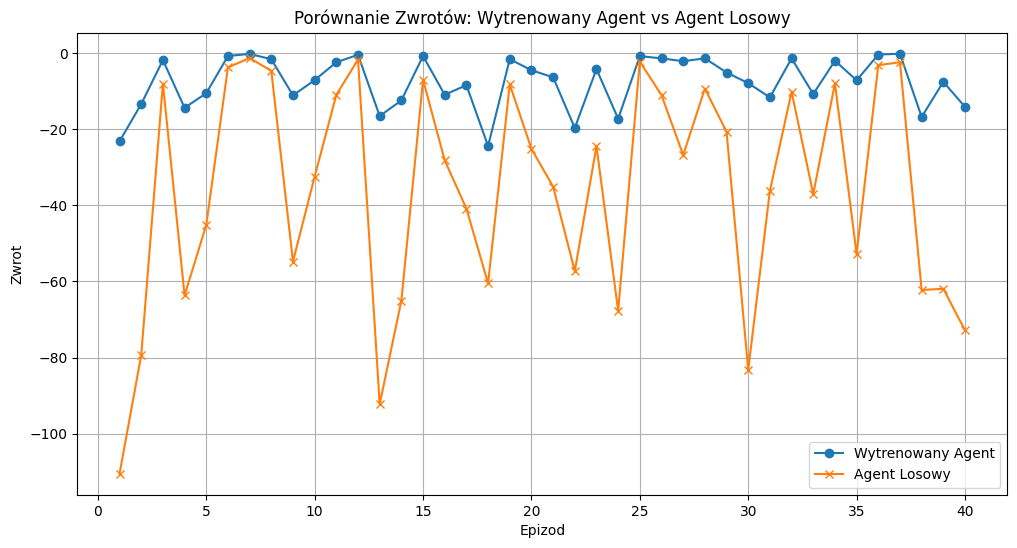

In [7]:
# %%
# Inicjalizacja wizualizatora agenta
# Upewnij się, że 'actor.pth' jest w tym samym katalogu co notebook lub podaj pełną ścieżkę
visualizer = AgentVisualizer(actor_path=save_point, device='cuda')  # lub 'cpu' jeśli nie masz GPU

# %%
# Sprawdzenie dostępnych trybów renderowania
print("Available render modes:", visualizer.env.metadata.get('render_modes', 'No render modes available'))

num_episodess=40

# %%
# Uruchomienie epizodów z wytrenowanym agentem
print("\n--- Uruchomienie epizodów z wytrenowanym agentem ---")
visualizer.run_episodes(
    num_episodes=num_episodess, 
    agent_type='trained', 
    render=False, 
    save_gif=True, 
    gif_path=f"{args.actor_path}{global_step}_Trained.gif"
)

# %%
# Uruchomienie epizodów z agentem losowym
print("\n--- Uruchomienie epizodów z agentem losowym ---")
visualizer.run_episodes(
    num_episodes=num_episodess, 
    agent_type='random', 
    render=False, 
    save_gif=True, 
    gif_path=f"{args.actor_path}{global_step}_Random.gif"
)

# %%
# Wyświetlenie wykresu zwrotów z obu agentów
print("\n--- Wykres porównujący zwroty wytrenowanego agenta z agentem losowym ---")
visualizer.plot_returns()
